<a href="https://colab.research.google.com/github/microsoft/autogen/blob/main/notebook/agentchat_function_call.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Auto Generated Agent Chat: Task Solving with Provided Tools as Functions

AutoGen offers conversable agents powered by LLM, tool, or human, which can be used to perform tasks collectively via automated chat. This framework allows tool use and human participation through multi-agent conversation. Please find documentation about this feature [here](https://microsoft.github.io/autogen/docs/Use-Cases/agent_chat).

In this notebook, we demonstrate how to use `AssistantAgent` and `UserProxyAgent` to make function calls with the new feature of OpenAI models (in model version 0613). A specified prompt and function configs must be passed to `AssistantAgent` to initialize the agent. The corresponding functions must be passed to `UserProxyAgent`, which will execute any function calls made by `AssistantAgent`. Besides this requirement of matching descriptions with functions, we recommend checking the system message in the `AssistantAgent` to ensure the instructions align with the function call descriptions.

## Requirements

AutoGen requires `Python>=3.8`. To run this notebook example, please install `pyautogen`:
```bash
pip install pyautogen
```

In [1]:
# %pip install "pyautogen~=0.2.0b2"

## Set your API Endpoint

The [`config_list_from_json`](https://microsoft.github.io/autogen/docs/reference/oai/openai_utils#config_list_from_json) function loads a list of configurations from an environment variable or a json file.

In [2]:
import autogen

config_list = autogen.config_list_from_json(
    "OAI_CONFIG_LIST",
    filter_dict={
        "model": ["gpt-4", "gpt-3.5-turbo", "gpt-3.5-turbo-16k"],
    },
)

It first looks for environment variable "OAI_CONFIG_LIST" which needs to be a valid json string. If that variable is not found, it then looks for a json file named "OAI_CONFIG_LIST". It filters the configs by models (you can filter by other keys as well). Only the models with matching names are kept in the list based on the filter condition.

The config list looks like the following:
```python
config_list = [
    {
        'model': 'gpt-4',
        'api_key': '<your OpenAI API key here>',
    },
    {
        'model': 'gpt-3.5-turbo',
        'api_key': '<your Azure OpenAI API key here>',
        'base_url': '<your Azure OpenAI API base here>',
        'api_type': 'azure',
        'api_version': '2023-08-01-preview',
    },
    {
        'model': 'gpt-3.5-turbo-16k',
        'api_key': '<your Azure OpenAI API key here>',
        'base_url': '<your Azure OpenAI API base here>',
        'api_type': 'azure',
        'api_version': '2023-08-01-preview',
    },
]
```

You can set the value of config_list in any way you prefer. Please refer to this [notebook](https://github.com/microsoft/autogen/blob/main/notebook/oai_openai_utils.ipynb) for full code examples of the different methods.

## Making Function Calls

In this example, we demonstrate function call execution with `AssistantAgent` and `UserProxyAgent`. With the default system prompt of `AssistantAgent`, we allow the LLM assistant to perform tasks with code, and the `UserProxyAgent` would extract code blocks from the LLM response and execute them. With the new "function_call" feature, we define functions and specify the description of the function in the OpenAI config for the `AssistantAgent`. Then we register the functions in `UserProxyAgent`.


user_proxy (to chatbot):

Draw two agents chatting with each other with an example dialog. Don't add plt.show().

--------------------------------------------------------------------------------
chatbot (to user_proxy):

***** Suggested function Call: python *****
Arguments: 
{
  "cell": "import matplotlib.pyplot as plt\n
# Initialize an empty figure and axis\n
fig, ax = plt.subplots()\n
# Create the chatboxes for messages\n
ax.text(0.5, 0.6, 'Agent1: Hi!', bbox=dict(facecolor='red', alpha=0.5))\n
ax.text(0.5, 0.5, 'Agent2: Hello!', bbox=dict(facecolor='blue', alpha=0.5))\n
plt.axis('off')"
}
*******************************************

--------------------------------------------------------------------------------

>>>>>>>> EXECUTING FUNCTION python...


(0.0, 1.0, 0.0, 1.0)

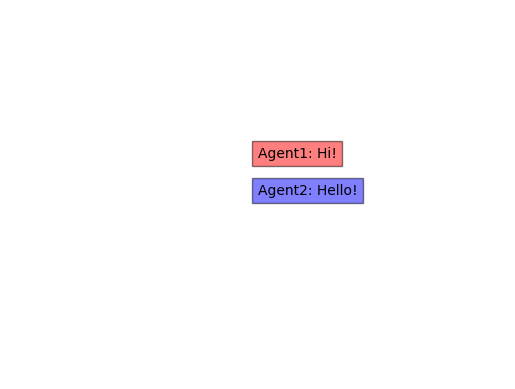

user_proxy (to chatbot):

***** Response from calling function "python" *****
(0.0, 1.0, 0.0, 1.0)
***************************************************

--------------------------------------------------------------------------------


In [3]:
llm_config = {
    "functions": [
        {
            "name": "python",
            "description": "run cell in ipython and return the execution result.",
            "parameters": {
                "type": "object",
                "properties": {
                    "cell": {
                        "type": "string",
                        "description": "Valid Python cell to execute.",
                    }
                },
                "required": ["cell"],
            },
        },
        {
            "name": "sh",
            "description": "run a shell script and return the execution result.",
            "parameters": {
                "type": "object",
                "properties": {
                    "script": {
                        "type": "string",
                        "description": "Valid shell script to execute.",
                    }
                },
                "required": ["script"],
            },
        },
    ],
    "config_list": config_list,
    "timeout": 120,
}
chatbot = autogen.AssistantAgent(
    name="chatbot",
    system_message="For coding tasks, only use the functions you have been provided with. Reply TERMINATE when the task is done.",
    llm_config=llm_config,
)

# create a UserProxyAgent instance named "user_proxy"
user_proxy = autogen.UserProxyAgent(
    name="user_proxy",
    is_termination_msg=lambda x: x.get("content", "") and x.get("content", "").rstrip().endswith("TERMINATE"),
    human_input_mode="NEVER",
    max_consecutive_auto_reply=10,
    code_execution_config={"work_dir": "coding"},
)

# define functions according to the function description
from IPython import get_ipython

def exec_python(cell):
    ipython = get_ipython()
    result = ipython.run_cell(cell)
    log = str(result.result)
    if result.error_before_exec is not None:
        log += f"\n{result.error_before_exec}"
    if result.error_in_exec is not None:
        log += f"\n{result.error_in_exec}"
    return log

def exec_sh(script):
    return user_proxy.execute_code_blocks([("sh", script)])

# register the functions
user_proxy.register_function(
    function_map={
        "python": exec_python,
        "sh": exec_sh,
    }
)

# start the conversation
user_proxy.initiate_chat(
    chatbot,
    message="Draw two agents chatting with each other with an example dialog. Don't add plt.show().",
)
